In [1]:
!pip install transformers torch scikit-learn nltk pandas numpy matplotlib seaborn

In [21]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
import torch
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akashjaiswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akashjaiswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [94]:
import pandas as pd

# Try loading the files one by one
df_clean_d_tweets = pd.read_csv('/Users/akashjaiswal/Desktop/Depression Detection/clean_d_tweets.csv')
df_clean_non_d_tweets = pd.read_csv('/Users/akashjaiswal/Desktop/Depression Detection/clean_non_d_tweets.csv')
df_d_tweets = pd.read_csv('/Users/akashjaiswal/Desktop/Depression Detection/d_tweets.csv')
df_non_d_tweets = pd.read_csv('/Users/akashjaiswal/Desktop/Depression Detection/non_d_tweets.csv')
df_reddit_depressed = pd.read_csv('/Users/akashjaiswal/Desktop/Depression Detection/depression_dataset_reddit_cleaned.csv')

# Now you can check if each dataframe is loaded correctly
print(df_clean_d_tweets.head())


                    id      conversation_id    created_at  \
0  1261623711502753792  1261623711502753792  1.589630e+12   
1  1255537912491343872  1255537912491343872  1.588179e+12   
2  1255524270521761792  1255524270521761792  1.588175e+12   
3  1255524059334365186  1255524059334365186  1.588175e+12   
4  1172463022100512769  1172463022100512769  1.568372e+12   

                  date  timezone  place  \
0  2020-05-16 01:45:07     -1000    NaN   
1  2020-04-29 06:42:19     -1000    NaN   
2  2020-04-29 05:48:07     -1000    NaN   
3  2020-04-29 05:47:16     -1000    NaN   
4  2019-09-13 00:52:22     -1000    NaN   

                                               tweet language hashtags  \
0  the real reason why you be sad you be attach t...       en       []   
1      my biggest problem be overthinking everything       en       []   
2  the worst sadness be the sadness you have teac...       en       []   
3  i cannot make you understand i cannot make any...       en       []   
4  i

In [95]:
   df_clean_d_tweets['label'] = 1  # Depressed
   df_clean_non_d_tweets['label'] = 0  # Non-depressed

In [96]:
twitter_df = pd.concat([df_clean_d_tweets, df_clean_non_d_tweets], ignore_index=True)

In [98]:
# List of possible text column names
text_columns = ['text', 'tweet', 'message', 'content', 'post', 'clean_text']

# Initialize variable to store the found text column
twitter_text_col = None

# Check if any of the columns in text_columns exists in the dataframe
for col in text_columns:
    if col in twitter_df.columns:
        twitter_text_col = col
        break

# If no text column is found, print a message and exit the process
if twitter_text_col is None:
    print(f"❌ No text column found. Available columns: {twitter_df.columns.tolist()}")
    # Optionally, you could add a 'return' here if the script is in a function, or simply end the code here.
    twitter_df = None  # or handle further action accordingly

# If the found text column is not 'text', rename it
if twitter_text_col != 'text':
    twitter_df.rename(columns={twitter_text_col: 'text'}, inplace=True)
    print(f"✓ Renamed column '{twitter_text_col}' to 'text'")

# Remove rows with missing text values
twitter_df = twitter_df.dropna(subset=['text'])

# Remove rows where the text column is empty or only contains whitespace
twitter_df = twitter_df[twitter_df['text'].astype(str).str.strip() != '']

# Print the shape of the cleaned dataset
print(f"✓ Twitter dataset shape after cleaning: {twitter_df.shape}")

# Example: Counting the number of 'depressed' and 'non-depressed' tweets
# Assuming 'twitter_depressed' and 'twitter_non_depressed' are defined elsewhere
print(f"  - Depressed tweets: {len(twitter_depressed)}")
print(f"  - Non-depressed tweets: {len(twitter_non_depressed)}")


✓ Twitter dataset shape after cleaning: (7745, 39)
  - Depressed tweets: 3082
  - Non-depressed tweets: 4687


In [99]:
if 'label' not in df_reddit_depressed.columns:
    # If no label column, check if it has both classes
    # Some datasets might have 'is_depression' or similar columns
    possible_label_cols = ['is_depression', 'depression', 'class', 'target']
    label_found = False
    
    for col in possible_label_cols:
        if col in df_reddit_depressed.columns:
            df_reddit_depressed['label'] = df_reddit_depressed[col]
            label_found = True
            print(f"✓ Using '{col}' as label column")
            break
    
    if not label_found:
        # Assume all are depressed
        df_reddit_depressed['label'] = 1
        print("⚠ No label column found. Assuming all posts are depression-related (label=1)")
else:
    print("✓ Reddit dataset already has labels")


✓ Using 'is_depression' as label column


In [100]:
reddit_text_col = None

# Check if any of the text columns exist in the dataset
for col in text_columns:
    if col in df_reddit_depressed.columns:
        reddit_text_col = col
        break

if reddit_text_col is None:
    print(f"❌ No text column found in Reddit data. Available columns: {df_reddit_depressed.columns.tolist()}")
    df_reddit_depressed = None
else:
    if reddit_text_col != 'text':
        df_reddit_depressed.rename(columns={reddit_text_col: 'text'}, inplace=True)
        print(f"✓ Renamed column '{reddit_text_col}' to 'text'")
    
    # Remove rows with missing or empty text
    df_reddit_depressed = df_reddit_depressed.dropna(subset=['text'])
    df_reddit_depressed = df_reddit_depressed[df_reddit_depressed['text'].astype(str).str.strip() != '']
    
    print(f"✓ Reddit dataset shape after cleaning: {df_reddit_depressed.shape}")
    
    # Check label distribution if 'label' column exists
    if 'label' in df_reddit_depressed.columns:
        label_counts = df_reddit_depressed['label'].value_counts()
        print(f"Reddit label distribution:")
        for label, count in label_counts.items():
            print(f"  - Label {label}: {count} posts")

# Exception handling for file not found (if needed)
try:
    # Your file reading process would go here
    # For example, if you're loading the Reddit data:
    # df_reddit_depressed = pd.read_csv('path_to_reddit_file.csv')
    pass
except FileNotFoundError as e:
    print(f"⚠ Reddit file not found: {e}")
    print("Continuing with Twitter dataset only.")
    df_reddit_depressed = None


✓ Renamed column 'clean_text' to 'text'
✓ Reddit dataset shape after cleaning: (7731, 3)
Reddit label distribution:
  - Label 0: 3900 posts
  - Label 1: 3831 posts


In [101]:
print(df_reddit_depressed.head(3900))

                                                   text  is_depression  label
0     we understand that most people who reply immed...              1      1
1     welcome to r depression s check in post a plac...              1      1
2     anyone else instead of sleeping more when depr...              1      1
3     i ve kind of stuffed around a lot in my life d...              1      1
4     sleep is my greatest and most comforting escap...              1      1
...                                                 ...            ...    ...
3895  i had such a nice day too bad the rain come in...              0      0
3896  starrbby too bad i won t be around i lost my j...              0      0
3897                       damm back to school tomorrow              0      0
3898  mo job no money how in the hell is min wage he...              0      0
3899                  katortiz not forever see you soon              0      0

[3900 rows x 3 columns]


In [102]:
class TextPreprocessor:
    """
    Text preprocessing following the research paper methodology
    """
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def remove_urls(self, text):
        """Remove URLs from text"""
        return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    def remove_mentions_hashtags(self, text):
        """Remove @mentions and #hashtags"""
        text = re.sub(r'@\w+', '', text)  # Remove @mentions
        text = re.sub(r'#\w+', '', text)  # Remove #hashtags
        return text
    
    def remove_special_characters(self, text):
        """Remove special characters and numbers"""
        return re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only alphabets and spaces
    
    def to_lowercase(self, text):
        """Convert text to lowercase"""
        return text.lower()
    
    def remove_stopwords(self, text):
        """Remove stopwords"""
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        return ' '.join(filtered_words)
    
    def remove_extra_spaces(self, text):
        """Remove extra whitespaces"""
        return ' '.join(text.split())  # Split and join to reduce multiple spaces
    
    def preprocess(self, text):
        """
        Complete preprocessing pipeline
        """
        if pd.isna(text):
            return ""  # Return an empty string if the text is NaN
        
        # Preprocessing pipeline
        text = str(text)  # Ensure text is a string
        
        text = self.remove_urls(text)
        text = self.remove_mentions_hashtags(text)
        text = self.to_lowercase(text)
        text = self.remove_special_characters(text)
        text = self.remove_stopwords(text)
        text = self.remove_extra_spaces(text)
        
        return text  # Return the preprocessed text

In [103]:
reddit_df= df_reddit_depressed

In [104]:
# Assuming reddit_df and twitter_df are your dataframes
# Initialize the TextPreprocessor
text_preprocessor = TextPreprocessor()

# Apply the preprocessing to the text column (e.g., 'text' or whichever column holds the text)
reddit_df['cleaned_text'] = reddit_df['text'].apply(lambda x: text_preprocessor.preprocess(x))
twitter_df['cleaned_text'] = twitter_df['text'].apply(lambda x: text_preprocessor.preprocess(x))

# Print a sample of the cleaned text for verification
print(reddit_df[['text', 'cleaned_text']].head())
print(twitter_df[['text', 'cleaned_text']].head())


                                                text  \
0  we understand that most people who reply immed...   
1  welcome to r depression s check in post a plac...   
2  anyone else instead of sleeping more when depr...   
3  i ve kind of stuffed around a lot in my life d...   
4  sleep is my greatest and most comforting escap...   

                                        cleaned_text  
0  understand people reply immediately op invitat...  
1  welcome r depression check post place take mom...  
2  anyone else instead sleeping depressed stay ni...  
3  kind stuffed around lot life delaying inevitab...  
4  sleep greatest comforting escape whenever wake...  
                                                text  \
0  the real reason why you be sad you be attach t...   
1      my biggest problem be overthinking everything   
2  the worst sadness be the sadness you have teac...   
3  i cannot make you understand i cannot make any...   
4  i do not think anyone really understand how ti... 

In [105]:
reddit_df.shape , twitter_df.shape

((7731, 4), (7745, 40))

In [109]:
twitter_df['cleaned_text'] = twitter_df['text'].apply(lambda x: text_preprocessor.preprocess(x))
twitter_df['label'] = twitter_df['label']  # Add labels back

# For Reddit
reddit_df['cleaned_text'] = reddit_df['text'].apply(lambda x: text_preprocessor.preprocess(x))
reddit_df['label'] = reddit_df['label']  # Add labels back

# Verify the result
print(twitter_df[['cleaned_text', 'label']].head())
print(reddit_df[['cleaned_text', 'label']].head())

                                        cleaned_text  label
0  real reason sad attach people distant pay atte...      1
1            biggest problem overthinking everything      1
2                   worst sadness sadness teach hide      1
3  cannot make understand cannot make anyone unde...      1
4  think anyone really understand tire act okay a...      1
                                        cleaned_text  label
0  understand people reply immediately op invitat...      1
1  welcome r depression check post place take mom...      1
2  anyone else instead sleeping depressed stay ni...      1
3  kind stuffed around lot life delaying inevitab...      1
4  sleep greatest comforting escape whenever wake...      1


In [111]:
reddit_df.shape , twitter_df.shape

((7731, 4), (7745, 40))

In [112]:
twitter_df.shape, reddit_df.shape

((7745, 40), (7731, 4))

In [128]:
"""
STEP 4: BERT EMBEDDINGS GENERATION - CORRECT CODE
Run these cells in order
"""

# ============================================================================
# CELL 1: DEFINE BERT EMBEDDING CLASS
# ============================================================================

import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

class BERTEmbeddings:
    """
    Generate BERT embeddings for text data using bert-base-uncased model.
    """
    def __init__(self, max_length=128):
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        # Load BERT model and tokenizer
        print("Loading BERT model...")
        try:
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = BertModel.from_pretrained('bert-base-uncased')
            self.model.to(self.device)
            self.model.eval()
            print("✓ BERT model loaded successfully!")
        except Exception as e:
            print(f"❌ Error loading BERT model: {e}")
            raise
    
    def get_embedding(self, text):
        """
        Generate embedding for a single text.
        """
        # Handle empty or invalid text
        if not text or pd.isna(text) or str(text).strip() == '':
            return np.zeros(768)  # Return zero vector for empty text
        
        try:
            # Tokenize
            encoding = self.tokenizer.encode_plus(
                str(text),
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(self.device)
            attention_mask = encoding['attention_mask'].to(self.device)
            
            # Generate embeddings
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                embeddings = outputs.last_hidden_state.mean(dim=1)
            
            return embeddings.cpu().numpy().flatten()
        
        except Exception as e:
            print(f"Error processing text: {str(text)[:50]}... Error: {e}")
            return np.zeros(768)
    
    def generate_embeddings(self, texts, batch_size=32):
        """
        Generate embeddings for multiple texts with progress tracking.
        """
        embeddings = []
        total = len(texts)
        
        print(f"Generating embeddings for {total} texts...")
        print(f"Batch size: {batch_size}")
        
        # Use tqdm for better progress visualization
        try:
            for i in tqdm(range(0, total, batch_size), desc="Processing batches"):
                batch = texts[i:i+batch_size]
                batch_embeddings = [self.get_embedding(text) for text in batch]
                embeddings.extend(batch_embeddings)
        except Exception as e:
            print(f"❌ Error during embedding generation: {e}")
            raise
        
        print("✓ Embeddings generated successfully!")
        return np.array(embeddings)


def generate_embeddings_for_datasets(twitter_df, reddit_df):
    """
    Generate BERT embeddings for both datasets.
    """
    print("\n" + "="*80)
    print("BERT EMBEDDING GENERATION")
    print("="*80)
    
    bert = BERTEmbeddings(max_length=128)
    
    # Generate Twitter embeddings
    print("\n=== Generating Twitter Embeddings ===")
    print(f"Total tweets to process: {len(twitter_df)}")
    twitter_embeddings = bert.generate_embeddings(
        twitter_df['cleaned_text'].tolist(), 
        batch_size=16
    )
    print(f"✓ Twitter embeddings shape: {twitter_embeddings.shape}")
    
    # Generate Reddit embeddings
    reddit_embeddings = None
    if reddit_df is not None:
        print("\n=== Generating Reddit Embeddings ===")
        print(f"Total posts to process: {len(reddit_df)}")
        reddit_embeddings = bert.generate_embeddings(
            reddit_df['cleaned_text'].tolist(), 
            batch_size=16
        )
        print(f"✓ Reddit embeddings shape: {reddit_embeddings.shape}")
    else:
        print("\n⚠ Skipping Reddit embeddings (dataset not available)")
    
    print("\n" + "="*80)
    return twitter_embeddings, reddit_embeddings

print("✓ BERT Embedding functions defined successfully!")

✓ BERT Embedding functions defined successfully!


In [129]:
print("="*80)
print("STARTING BERT EMBEDDING GENERATION")
print("="*80)
print("\n⚠️ WARNING: This will take 5-10 minutes depending on dataset size!")
print("Please be patient...\n")

STARTING BERT EMBEDDING GENERATION

⚠️ WARNING: This will take 5-10 minutes depending on dataset size!
Please be patient...



In [169]:
pip install torch torchvision torchaudio


Note: you may need to restart the kernel to use updated packages.


In [172]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create a tensor and move it to the GPU
tensor = torch.randn(3, 3)
tensor = tensor.to(device)

print(tensor)


Using device: cpu
tensor([[-0.0347,  0.5320,  0.3857],
        [-1.2687, -1.0752,  0.5061],
        [-1.0221, -0.7630, -1.8042]])


In [143]:
twitter_embeddings, reddit_embeddings = generate_embeddings_for_datasets(twitter_df, reddit_df)


BERT EMBEDDING GENERATION
Using device: cpu
Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

✓ BERT model loaded successfully!

=== Generating Twitter Embeddings ===
Total tweets to process: 7745
Generating embeddings for 7745 texts...
Batch size: 16


Processing batches: 100%|██████████| 485/485 [05:09<00:00,  1.57it/s]


✓ Embeddings generated successfully!
✓ Twitter embeddings shape: (7745, 768)

=== Generating Reddit Embeddings ===
Total posts to process: 7731
Generating embeddings for 7731 texts...
Batch size: 16


Processing batches: 100%|██████████| 484/484 [05:28<00:00,  1.47it/s]

✓ Embeddings generated successfully!
✓ Reddit embeddings shape: (7731, 768)



In [144]:
print("\n💾 Saving embeddings to disk...")
np.save('twitter_embeddings.npy', twitter_embeddings)
if reddit_embeddings is not None:
    np.save('reddit_embeddings.npy', reddit_embeddings)
print("✅ Embeddings saved!")


💾 Saving embeddings to disk...
✅ Embeddings saved!



🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
DEPRESSION DETECTION - UNIFIED MODEL TRAINING
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

COMBINING DATASETS

Twitter dataset:
  - Samples: 7745
  - Features: 768
  - Label distribution: [4670 3075]

Reddit dataset:
  - Samples: 7731
  - Features: 768
  - Label distribution: [3900 3831]

Combined dataset:
  - Total samples: 15476
  - Features: 768
  - Label distribution:
    * Non-depressed (0): 8570
    * Depressed (1): 6906
  - Class balance: 44.6% depressed


📊 Splitting dataset (80% train, 20% test)...

Training set: 12380 samples
  - Non-depressed: 6856
  - Depressed: 5524

Test set: 3096 samples
  - Non-depressed: 1714
  - Depressed: 1382

🚀 Starting training...


TRAINING SVM MODELS ON COMBINED DATASET

Training SVM with LINEAR kernel
Parameters: C=1.0, gamma=scale
Training on 12380 samples...

📊 RESULTS:
  Accuracy: 86.47%

  Class 0 (Non-Depressed):
    - Precision: 0.873
    - Recall: 0.884
    - F1-Score: 0.879

  Class 1 (Depressed):


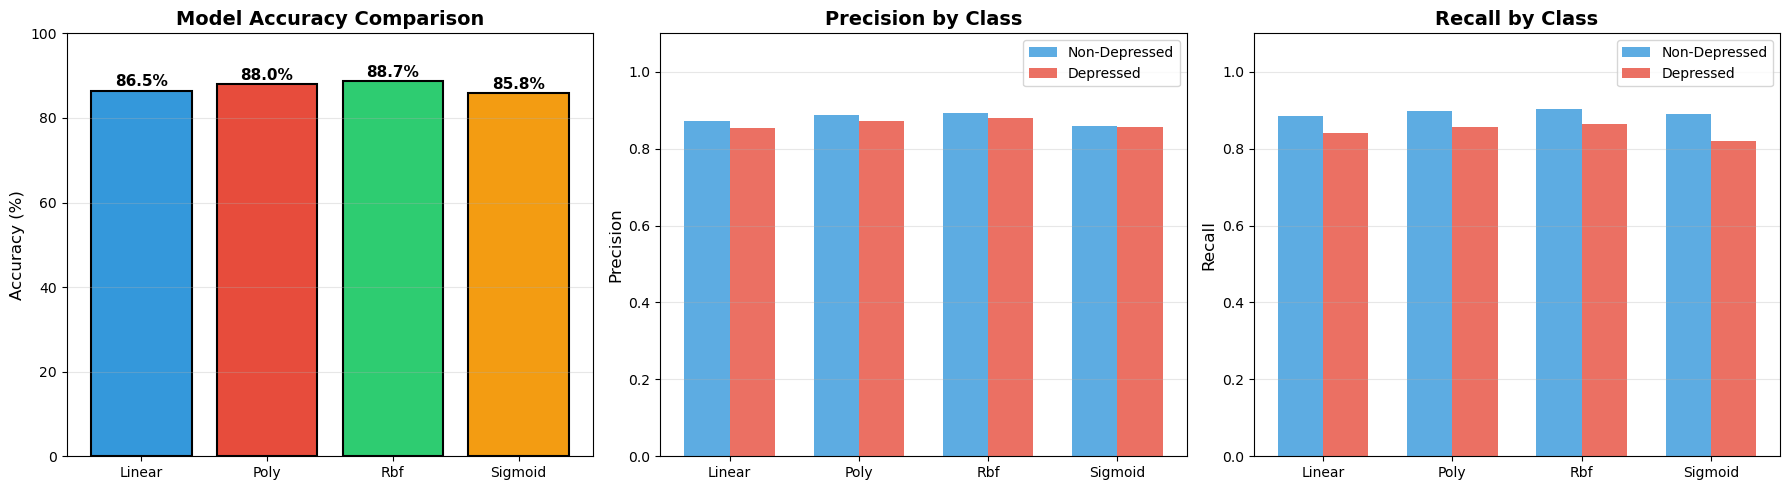

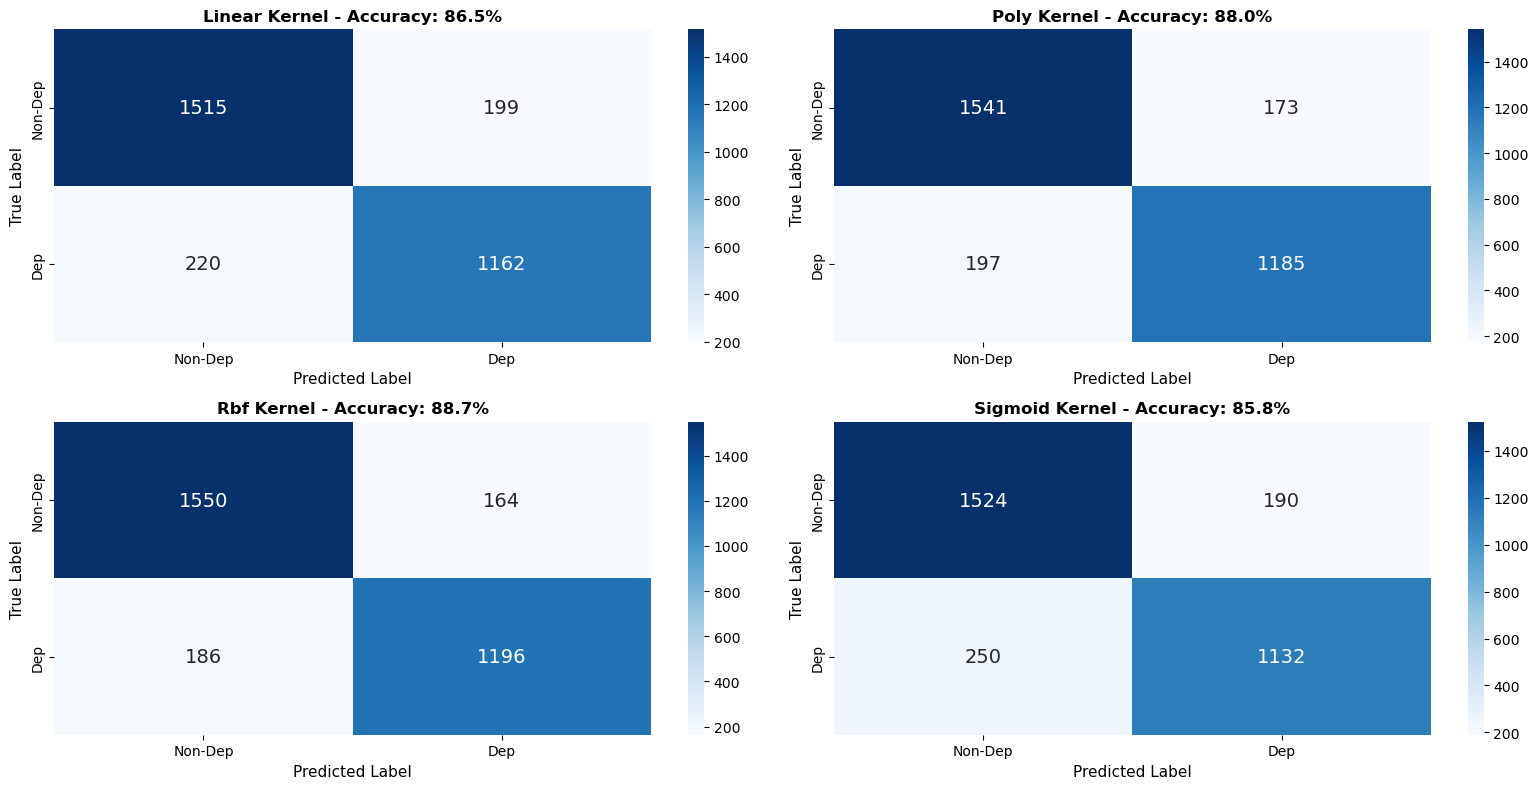


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
BEST MODEL: RBF KERNEL
ACCURACY: 88.70%
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

💾 Saving best model...
✅ Model saved as 'depression_detection_model.pkl'

💾 Saving complete pipeline...
✅ Complete pipeline saved!

✅ TRAINING COMPLETE! MODEL READY FOR DEPLOYMENT!


In [159]:
"""
DEPRESSION DETECTION - COMBINED DATASET TRAINING
Train a single unified model on both Twitter and Reddit data
"""

# ============================================================================
# STEP 1: COMBINE DATASETS
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def combine_datasets(twitter_embeddings, twitter_labels, reddit_embeddings, reddit_labels):
    """
    Combine Twitter and Reddit datasets into one unified dataset
    """
    print("\n" + "="*80)
    print("COMBINING DATASETS")
    print("="*80)
    
    print(f"\nTwitter dataset:")
    print(f"  - Samples: {len(twitter_embeddings)}")
    print(f"  - Features: {twitter_embeddings.shape[1]}")
    print(f"  - Label distribution: {np.bincount(twitter_labels)}")
    
    if reddit_embeddings is not None and reddit_labels is not None:
        print(f"\nReddit dataset:")
        print(f"  - Samples: {len(reddit_embeddings)}")
        print(f"  - Features: {reddit_embeddings.shape[1]}")
        print(f"  - Label distribution: {np.bincount(reddit_labels)}")
        
        # Combine both datasets
        combined_embeddings = np.vstack([twitter_embeddings, reddit_embeddings])
        combined_labels = np.concatenate([twitter_labels, reddit_labels])
    else:
        print("\n⚠ Reddit dataset not available, using only Twitter")
        combined_embeddings = twitter_embeddings
        combined_labels = twitter_labels
    
    print(f"\nCombined dataset:")
    print(f"  - Total samples: {len(combined_embeddings)}")
    print(f"  - Features: {combined_embeddings.shape[1]}")
    print(f"  - Label distribution:")
    print(f"    * Non-depressed (0): {np.sum(combined_labels == 0)}")
    print(f"    * Depressed (1): {np.sum(combined_labels == 1)}")
    print(f"  - Class balance: {np.sum(combined_labels == 1) / len(combined_labels) * 100:.1f}% depressed")
    
    print("\n" + "="*80)
    
    return combined_embeddings, combined_labels

# ============================================================================
# STEP 2: TRAIN SVM WITH ALL KERNELS
# ============================================================================

def train_combined_model(X_train, y_train, X_test, y_test, kernel='linear', C=1.0, gamma='scale'):
    """
    Train SVM with specified kernel
    """
    print(f"\n{'='*60}")
    print(f"Training SVM with {kernel.upper()} kernel")
    print(f"{'='*60}")
    print(f"Parameters: C={C}, gamma={gamma}")
    
    # Create and train model
    if kernel == 'linear':
        model = SVC(kernel=kernel, C=C, random_state=42)
    else:
        model = SVC(kernel=kernel, C=C, gamma=gamma, random_state=42)
    
    print(f"Training on {len(X_train)} samples...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    # Display results
    print(f"\n📊 RESULTS:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"\n  Class 0 (Non-Depressed):")
    print(f"    - Precision: {precision[0]:.3f}")
    print(f"    - Recall: {recall[0]:.3f}")
    print(f"    - F1-Score: {f1[0]:.3f}")
    print(f"\n  Class 1 (Depressed):")
    print(f"    - Precision: {precision[1]:.3f}")
    print(f"    - Recall: {recall[1]:.3f}")
    print(f"    - F1-Score: {f1[1]:.3f}")
    
    return model, accuracy, precision, recall, f1, y_pred

def train_all_kernels_combined(X_train, y_train, X_test, y_test):
    """
    Train SVM with all kernel functions on combined dataset
    """
    print("\n" + "="*80)
    print("TRAINING SVM MODELS ON COMBINED DATASET")
    print("="*80)
    
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    
    # Hyperparameters (optimized based on research)
    params = {
        'linear': {'C': 1.0, 'gamma': 'scale'},
        'poly': {'C': 10.0, 'gamma': 0.1},
        'rbf': {'C': 10.0, 'gamma': 0.01},
        'sigmoid': {'C': 1.0, 'gamma': 0.01}
    }
    
    results = []
    models = {}
    predictions = {}
    
    for kernel in kernels:
        model, acc, prec, rec, f1, y_pred = train_combined_model(
            X_train, y_train, X_test, y_test,
            kernel=kernel,
            C=params[kernel]['C'],
            gamma=params[kernel]['gamma']
        )
        
        models[kernel] = model
        predictions[kernel] = y_pred
        
        results.append({
            'Kernel': kernel.capitalize(),
            'Accuracy': f"{acc*100:.2f}%",
            'Precision_Non_Dep': f"{prec[0]:.3f}",
            'Precision_Dep': f"{prec[1]:.3f}",
            'Recall_Non_Dep': f"{rec[0]:.3f}",
            'Recall_Dep': f"{rec[1]:.3f}",
            'F1_Non_Dep': f"{f1[0]:.3f}",
            'F1_Dep': f"{f1[1]:.3f}"
        })
    
    results_df = pd.DataFrame(results)
    
    print("\n" + "="*80)
    print("✅ TRAINING COMPLETE!")
    print("="*80)
    
    return models, predictions, results_df

# ============================================================================
# STEP 3: VISUALIZE RESULTS
# ============================================================================

def plot_combined_results(results_df, y_test, predictions, models):
    """
    Create comprehensive visualizations
    """
    kernels = results_df['Kernel'].tolist()
    accuracies = [float(x.strip('%')) for x in results_df['Accuracy']]
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    # Figure 1: Accuracy and Metrics Comparison
    fig1 = plt.figure(figsize=(18, 5))
    
    # 1. Accuracy Comparison
    ax1 = plt.subplot(1, 3, 1)
    bars = ax1.bar(kernels, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_ylim([0, 100])
    ax1.grid(axis='y', alpha=0.3)
    
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax1.text(bar.get_x() + bar.get_width()/2, acc + 1, 
                f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=11)
    
    # 2. Precision Comparison
    ax2 = plt.subplot(1, 3, 2)
    prec_dep = [float(results_df.iloc[i]['Precision_Dep']) for i in range(len(results_df))]
    prec_non_dep = [float(results_df.iloc[i]['Precision_Non_Dep']) for i in range(len(results_df))]
    
    x = np.arange(len(kernels))
    width = 0.35
    
    ax2.bar(x - width/2, prec_non_dep, width, label='Non-Depressed', color='#3498db', alpha=0.8)
    ax2.bar(x + width/2, prec_dep, width, label='Depressed', color='#e74c3c', alpha=0.8)
    ax2.set_title('Precision by Class', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(kernels)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim([0, 1.1])
    
    # 3. Recall Comparison
    ax3 = plt.subplot(1, 3, 3)
    rec_dep = [float(results_df.iloc[i]['Recall_Dep']) for i in range(len(results_df))]
    rec_non_dep = [float(results_df.iloc[i]['Recall_Non_Dep']) for i in range(len(results_df))]
    
    ax3.bar(x - width/2, rec_non_dep, width, label='Non-Depressed', color='#3498db', alpha=0.8)
    ax3.bar(x + width/2, rec_dep, width, label='Depressed', color='#e74c3c', alpha=0.8)
    ax3.set_title('Recall by Class', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Recall', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(kernels)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    ax3.set_ylim([0, 1.1])
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Confusion Matrices
    fig2 = plt.figure(figsize=(16, 8))
    
    for idx, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
        ax = plt.subplot(2, 2, idx + 1)
        cm = confusion_matrix(y_test, predictions[kernel])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Non-Dep', 'Dep'],
                    yticklabels=['Non-Dep', 'Dep'],
                    cbar=True, annot_kws={'size': 14})
        
        kernel_acc = accuracies[idx]
        ax.set_title(f'{kernel.capitalize()} Kernel - Accuracy: {kernel_acc:.1f}%', 
                    fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=11)
        ax.set_xlabel('Predicted Label', fontsize=11)
    
    plt.tight_layout()
    plt.show()

def display_detailed_results(results_df):
    """
    Display formatted results table
    """
    print("\n" + "="*120)
    print("DETAILED RESULTS - COMBINED DATASET")
    print("="*120)
    print(results_df.to_string(index=False))
    print("="*120)

# ============================================================================
# STEP 4: MAIN EXECUTION
# ============================================================================

print("\n" + "🎯"*40)
print("DEPRESSION DETECTION - UNIFIED MODEL TRAINING")
print("🎯"*40)

# Combine datasets
combined_embeddings, combined_labels = combine_datasets(
    twitter_embeddings, 
    twitter_df['label'].values,
    reddit_embeddings if reddit_embeddings is not None else None,
    reddit_df['label'].values if reddit_df is not None else None
)

# Split into train/test
print("\n📊 Splitting dataset (80% train, 20% test)...")
X_train, X_test, y_train, y_test = train_test_split(
    combined_embeddings, 
    combined_labels,
    test_size=0.2,
    random_state=42,
    stratify=combined_labels
)

print(f"\nTraining set: {len(X_train)} samples")
print(f"  - Non-depressed: {np.sum(y_train == 0)}")
print(f"  - Depressed: {np.sum(y_train == 1)}")

print(f"\nTest set: {len(X_test)} samples")
print(f"  - Non-depressed: {np.sum(y_test == 0)}")
print(f"  - Depressed: {np.sum(y_test == 1)}")

# Train all models
print("\n🚀 Starting training...\n")
models, predictions, results_df = train_all_kernels_combined(X_train, y_train, X_test, y_test)

# Display results
display_detailed_results(results_df)

# Plot results
print("\n📈 Generating visualizations...\n")
plot_combined_results(results_df, y_test, predictions, models)

# Find best model
best_idx = results_df['Accuracy'].apply(lambda x: float(x.strip('%'))).idxmax()
best_kernel = results_df.iloc[best_idx]['Kernel'].lower()
best_accuracy = results_df.iloc[best_idx]['Accuracy']

print("\n" + "🏆"*40)
print(f"BEST MODEL: {best_kernel.upper()} KERNEL")
print(f"ACCURACY: {best_accuracy}")
print("🏆"*40)

# ============================================================================
# STEP 5: SAVE BEST MODEL
# ============================================================================

import pickle

print("\n💾 Saving best model...")
best_model = models[best_kernel]

with open('depression_detection_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"✅ Model saved as 'depression_detection_model.pkl'")

# Also save preprocessing objects
print("\n💾 Saving complete pipeline...")
pipeline = {
    'model': best_model,
    'kernel': best_kernel,
    'accuracy': best_accuracy,
    'feature_size': combined_embeddings.shape[1]
}

with open('depression_detection_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("✅ Complete pipeline saved!")

print("\n" + "="*80)
print("✅ TRAINING COMPLETE! MODEL READY FOR DEPLOYMENT!")
print("="*80)

In [160]:
"""
DEPRESSION DETECTION - PREDICTION SYSTEM
Use trained model to predict depression from new text
"""

# ============================================================================
# STEP 1: LOAD TRAINED MODEL AND PREPROCESSING TOOLS
# ============================================================================

import pickle
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import torch
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')

class DepressionDetector:
    """
    Complete depression detection system with preprocessing and prediction
    """
    def __init__(self, model_path='depression_detection_model.pkl'):
        """
        Initialize the depression detector
        """
        print("="*80)
        print("INITIALIZING DEPRESSION DETECTION SYSTEM")
        print("="*80)
        
        # Load trained model
        print("\n1. Loading trained model...")
        try:
            with open(model_path, 'rb') as f:
                self.model = pickle.load(f)
            print(f"   ✓ Model loaded from {model_path}")
        except FileNotFoundError:
            print(f"   ❌ Model file not found: {model_path}")
            print("   Please train the model first!")
            raise
        
        # Initialize preprocessing
        print("\n2. Initializing text preprocessing...")
        self.stop_words = set(stopwords.words('english'))
        print("   ✓ Stopwords loaded")
        
        # Initialize BERT
        print("\n3. Loading BERT model...")
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_model.to(self.device)
        self.bert_model.eval()
        print(f"   ✓ BERT model loaded on {self.device}")
        
        print("\n" + "="*80)
        print("✅ SYSTEM READY FOR PREDICTIONS!")
        print("="*80 + "\n")
    
    def preprocess_text(self, text):
        """
        Preprocess text (same as training preprocessing)
        """
        if pd.isna(text) or not text:
            return ""
        
        text = str(text)
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove stopwords
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        text = ' '.join(filtered_words)
        
        # Remove extra spaces
        text = ' '.join(text.split())
        
        return text
    
    def get_bert_embedding(self, text, max_length=128):
        """
        Generate BERT embedding for text
        """
        if not text or text.strip() == '':
            return np.zeros(768)
        
        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        # Generate embedding
        with torch.no_grad():
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.last_hidden_state.mean(dim=1)
        
        return embedding.cpu().numpy().flatten()
    
    def predict(self, text, return_probability=False):
        """
        Predict depression from text
        
        Parameters:
        -----------
        text : str
            Input text to analyze
        return_probability : bool
            If True, return confidence scores (if model supports it)
        
        Returns:
        --------
        prediction : str
            'Depressed' or 'Non-Depressed'
        """
        # Preprocess
        cleaned_text = self.preprocess_text(text)
        
        if not cleaned_text:
            return "Unable to analyze (empty text after preprocessing)"
        
        # Generate embedding
        embedding = self.get_bert_embedding(cleaned_text)
        embedding = embedding.reshape(1, -1)
        
        # Predict
        prediction = self.model.predict(embedding)[0]
        
        result = "Depressed" if prediction == 1 else "Non-Depressed"
        
        return result
    
    def predict_batch(self, texts):
        """
        Predict depression for multiple texts
        """
        results = []
        
        print(f"\nAnalyzing {len(texts)} texts...")
        
        for i, text in enumerate(texts):
            prediction = self.predict(text)
            results.append({
                'text': text[:100] + '...' if len(text) > 100 else text,
                'prediction': prediction
            })
            
            if (i + 1) % 10 == 0:
                print(f"  Processed {i + 1}/{len(texts)}")
        
        return pd.DataFrame(results)
    
    def analyze_text_detailed(self, text):
        """
        Detailed analysis with preprocessing steps shown
        """
        print("\n" + "="*80)
        print("DETAILED ANALYSIS")
        print("="*80)
        
        print(f"\n📝 Original Text:")
        print(f"   {text[:200]}{'...' if len(text) > 200 else ''}")
        
        # Preprocess
        cleaned_text = self.preprocess_text(text)
        print(f"\n🧹 Cleaned Text:")
        print(f"   {cleaned_text[:200]}{'...' if len(cleaned_text) > 200 else ''}")
        
        if not cleaned_text:
            print("\n⚠️ Text became empty after preprocessing!")
            return
        
        # Generate embedding
        print(f"\n🔢 Generating BERT embedding...")
        embedding = self.get_bert_embedding(cleaned_text)
        print(f"   Embedding shape: {embedding.shape}")
        
        # Predict
        print(f"\n🤖 Making prediction...")
        embedding_reshaped = embedding.reshape(1, -1)
        prediction = self.model.predict(embedding_reshaped)[0]
        
        result = "Depressed" if prediction == 1 else "Non-Depressed"
        
        print("\n" + "="*80)
        print(f"📊 PREDICTION: {result}")
        print("="*80 + "\n")
        
        return result

# ============================================================================
# STEP 2: INITIALIZE THE DETECTOR
# ============================================================================

print("Initializing Depression Detector...")
detector = DepressionDetector()

# ============================================================================
# STEP 3: EXAMPLE PREDICTIONS
# ============================================================================

print("\n" + "🔍"*40)
print("TESTING THE DEPRESSION DETECTION SYSTEM")
print("🔍"*40)

# Test cases
test_texts = [
    # Depressed examples
    "I feel so hopeless and alone. Nothing seems to matter anymore. I can't find joy in anything.",
    "Every day feels like a struggle. I'm tired all the time and don't want to get out of bed.",
    "I hate myself and don't see the point in continuing. Life feels meaningless.",
    
    # Non-depressed examples
    "Had an amazing day at the park! The weather was beautiful and I'm feeling great!",
    "Just finished a great workout. Feeling energized and ready for the day!",
    "Excited about the new project at work. Can't wait to get started tomorrow!",
    
    # Neutral/ambiguous
    "Going to the store later to buy groceries.",
    "The meeting is scheduled for 3pm today.",
]

print("\n" + "-"*80)
print("SAMPLE PREDICTIONS")
print("-"*80)

for i, text in enumerate(test_texts, 1):
    prediction = detector.predict(text)
    print(f"\n{i}. Text: {text[:80]}...")
    print(f"   Prediction: {prediction}")

# ============================================================================
# STEP 4: DETAILED ANALYSIS EXAMPLE
# ============================================================================

print("\n\n" + "🔬"*40)
print("DETAILED ANALYSIS EXAMPLE")
print("🔬"*40)

sample_text = "I've been feeling really down lately. Nothing brings me happiness anymore. I just want to stay in bed all day and avoid everyone."

detector.analyze_text_detailed(sample_text)

# ============================================================================
# STEP 5: BATCH PREDICTION EXAMPLE
# ============================================================================

print("\n" + "📊"*40)
print("BATCH PREDICTION EXAMPLE")
print("📊"*40)

batch_texts = [
    "Feeling sad and overwhelmed. Don't know what to do.",
    "Beautiful sunrise this morning! Life is good!",
    "Can't stop crying. Everything feels hopeless.",
    "Just got promoted at work! So happy and grateful!",
    "No energy to do anything. Just want to sleep forever.",
]

batch_results = detector.predict_batch(batch_texts)

print("\n" + "="*80)
print("BATCH RESULTS")
print("="*80)
print(batch_results.to_string(index=False))
print("="*80)

# ============================================================================
# STEP 6: INTERACTIVE PREDICTION FUNCTION
# ============================================================================

def predict_depression(text):
    """
    Quick prediction function - Use this for easy predictions
    """
    prediction = detector.predict(text)
    
    print("\n" + "="*60)
    print(f"Text: {text[:100]}...")
    print(f"Prediction: {prediction}")
    print("="*60)
    
    return prediction

# ============================================================================
# STEP 7: YOUR OWN PREDICTIONS - USE THIS!
# ============================================================================

print("\n\n" + "🎯"*40)
print("YOUR TURN - TRY YOUR OWN TEXT!")
print("🎯"*40)

print("\nUse this function to predict:")
print("predict_depression('Your text here')")

print("\nOr detailed analysis:")
print("detector.analyze_text_detailed('Your text here')")

print("\n" + "="*80)
print("✅ SYSTEM READY! START MAKING PREDICTIONS!")
print("="*80)

# ============================================================================
# EXAMPLE USAGE:
# ============================================================================

# Uncomment to test:
# predict_depression("I feel so depressed and hopeless today")
# predict_depression("Having a wonderful day with friends!")

# ============================================================================
# STEP 8: SAVE PREDICTIONS TO FILE (OPTIONAL)
# ============================================================================

def save_predictions_to_csv(texts, output_file='predictions.csv'):
    """
    Predict for multiple texts and save to CSV
    """
    results = detector.predict_batch(texts)
    results.to_csv(output_file, index=False)
    print(f"\n✅ Predictions saved to {output_file}")
    return results

# Example:
# my_texts = ["text1", "text2", "text3"]
# save_predictions_to_csv(my_texts)

Initializing Depression Detector...
INITIALIZING DEPRESSION DETECTION SYSTEM

1. Loading trained model...
   ✓ Model loaded from depression_detection_model.pkl

2. Initializing text preprocessing...
   ✓ Stopwords loaded

3. Loading BERT model...
   ✓ BERT model loaded on cpu

✅ SYSTEM READY FOR PREDICTIONS!


🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
TESTING THE DEPRESSION DETECTION SYSTEM
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

--------------------------------------------------------------------------------
SAMPLE PREDICTIONS
--------------------------------------------------------------------------------

1. Text: I feel so hopeless and alone. Nothing seems to matter anymore. I can't find joy ...
   Prediction: Depressed

2. Text: Every day feels like a struggle. I'm tired all the time and don't want to get ou...
   Prediction: Depressed

3. Text: I hate myself and don't see the point in continuing. Life feels meaningless....
   Prediction: Depressed

4. Text: Had an amazing day at

In [161]:
texts = [
    "I'm so depressed and can't stop crying",
    "Had the best day ever! So grateful!",
    "Feeling empty and alone"
]

results = detector.predict_batch(texts)
print(results)


Analyzing 3 texts...
                                     text     prediction
0  I'm so depressed and can't stop crying  Non-Depressed
1     Had the best day ever! So grateful!  Non-Depressed
2                 Feeling empty and alone  Non-Depressed


In [162]:
predict_depression("i'm feeling really low and hopeless today")


Text: i'm feeling really low and hopeless today...
Prediction: Non-Depressed


'Non-Depressed'

In [165]:
predict_depression("about to dead")


Text: about to dead...
Prediction: Depressed


'Depressed'

In [166]:
# Compare all 4 models on same text
def compare_all_models(text):
    """
    Compare predictions from all 4 kernels
    """
    print("\n" + "="*80)
    print("COMPARING ALL MODEL PREDICTIONS")
    print("="*80)
    print(f"\nText: {text}\n")
    
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    
    for kernel in kernels:
        # Load model
        model = models[kernel]  # From training step
        
        # Preprocess
        cleaned = detector.preprocess_text(text)
        embedding = detector.get_bert_embedding(cleaned).reshape(1, -1)
        
        # Predict
        pred = model.predict(embedding)[0]
        result = "Depressed" if pred == 1 else "Non-Depressed"
        
        print(f"{kernel.upper():10} → {result}")
    
    print("="*80)

# Test
compare_all_models("I feel so hopeless and sad")


COMPARING ALL MODEL PREDICTIONS

Text: I feel so hopeless and sad

LINEAR     → Depressed
POLY       → Depressed
RBF        → Depressed
SIGMOID    → Depressed


In [167]:
"""
DEPRESSION DETECTION - GRAPHICAL USER INTERFACE (GUI)
Simple and Professional Interface using Tkinter
"""

import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox, filedialog
import pickle
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import torch
from transformers import BertTokenizer, BertModel
import warnings
warnings.filterwarnings('ignore')

class DepressionDetectionGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Depression Detection System")
        self.root.geometry("900x700")
        self.root.configure(bg='#f0f0f0')
        
        # Initialize detector
        self.detector = None
        self.init_detector()
        
        # Create GUI
        self.create_widgets()
    
    def init_detector(self):
        """Initialize the depression detector"""
        try:
            print("Loading model...")
            
            # Load model
            with open('depression_detection_model.pkl', 'rb') as f:
                self.model = pickle.load(f)
            
            # Get model info
            self.model_kernel = self.model.kernel
            
            # Initialize preprocessing
            self.stop_words = set(stopwords.words('english'))
            
            # Initialize BERT
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')
            self.bert_model.to(self.device)
            self.bert_model.eval()
            
            print("✓ Model loaded successfully!")
            self.model_loaded = True
            
        except Exception as e:
            print(f"Error loading model: {e}")
            self.model_loaded = False
            messagebox.showerror("Error", f"Failed to load model:\n{str(e)}")
    
    def create_widgets(self):
        """Create GUI widgets"""
        
        # ===== HEADER =====
        header_frame = tk.Frame(self.root, bg='#2c3e50', height=80)
        header_frame.pack(fill='x', pady=0)
        
        title_label = tk.Label(
            header_frame, 
            text="🧠 Depression Detection System",
            font=('Arial', 24, 'bold'),
            bg='#2c3e50',
            fg='white'
        )
        title_label.pack(pady=20)
        
        # ===== MODEL INFO =====
        info_frame = tk.Frame(self.root, bg='#ecf0f1', height=50)
        info_frame.pack(fill='x', pady=5)
        
        if self.model_loaded:
            model_info = f"📊 Model: SVM ({self.model_kernel.upper()} Kernel) | Device: {self.device}"
        else:
            model_info = "⚠️ Model not loaded"
        
        info_label = tk.Label(
            info_frame,
            text=model_info,
            font=('Arial', 10),
            bg='#ecf0f1',
            fg='#2c3e50'
        )
        info_label.pack(pady=10)
        
        # ===== MAIN CONTENT =====
        main_frame = tk.Frame(self.root, bg='#f0f0f0')
        main_frame.pack(fill='both', expand=True, padx=20, pady=10)
        
        # Input Section
        input_label = tk.Label(
            main_frame,
            text="Enter Text to Analyze:",
            font=('Arial', 12, 'bold'),
            bg='#f0f0f0',
            fg='#2c3e50'
        )
        input_label.pack(anchor='w', pady=(10, 5))
        
        self.input_text = scrolledtext.ScrolledText(
            main_frame,
            height=8,
            font=('Arial', 11),
            wrap=tk.WORD,
            bg='white',
            fg='#2c3e50',
            relief=tk.SOLID,
            borderwidth=1
        )
        self.input_text.pack(fill='both', expand=True, pady=(0, 10))
        
        # Buttons Frame
        button_frame = tk.Frame(main_frame, bg='#f0f0f0')
        button_frame.pack(pady=10)
        
        # Analyze Button
        self.analyze_btn = tk.Button(
            button_frame,
            text="🔍 Analyze Text",
            command=self.analyze_text,
            font=('Arial', 12, 'bold'),
            bg='#3498db',
            fg='white',
            width=15,
            height=2,
            relief=tk.FLAT,
            cursor='hand2'
        )
        self.analyze_btn.pack(side='left', padx=5)
        
        # Clear Button
        clear_btn = tk.Button(
            button_frame,
            text="🗑️ Clear",
            command=self.clear_fields,
            font=('Arial', 12, 'bold'),
            bg='#95a5a6',
            fg='white',
            width=10,
            height=2,
            relief=tk.FLAT,
            cursor='hand2'
        )
        clear_btn.pack(side='left', padx=5)
        
        # Sample Text Button
        sample_btn = tk.Button(
            button_frame,
            text="📝 Sample Text",
            command=self.load_sample_text,
            font=('Arial', 12, 'bold'),
            bg='#9b59b6',
            fg='white',
            width=12,
            height=2,
            relief=tk.FLAT,
            cursor='hand2'
        )
        sample_btn.pack(side='left', padx=5)
        
        # Results Section
        result_label = tk.Label(
            main_frame,
            text="Analysis Results:",
            font=('Arial', 12, 'bold'),
            bg='#f0f0f0',
            fg='#2c3e50'
        )
        result_label.pack(anchor='w', pady=(20, 5))
        
        self.result_text = scrolledtext.ScrolledText(
            main_frame,
            height=8,
            font=('Arial', 11),
            wrap=tk.WORD,
            bg='#ecf0f1',
            fg='#2c3e50',
            relief=tk.SOLID,
            borderwidth=1,
            state='disabled'
        )
        self.result_text.pack(fill='both', expand=True)
        
        # ===== FOOTER =====
        footer_frame = tk.Frame(self.root, bg='#2c3e50', height=40)
        footer_frame.pack(fill='x', side='bottom')
        
        footer_label = tk.Label(
            footer_frame,
            text="Depression Detection using BERT & SVM | Developed for Mental Health Research",
            font=('Arial', 9),
            bg='#2c3e50',
            fg='white'
        )
        footer_label.pack(pady=10)
    
    def preprocess_text(self, text):
        """Preprocess input text"""
        if pd.isna(text) or not text:
            return ""
        
        text = str(text)
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#\w+', '', text)
        text = text.lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        words = text.split()
        filtered_words = [word for word in words if word not in self.stop_words]
        text = ' '.join(filtered_words)
        text = ' '.join(text.split())
        
        return text
    
    def get_bert_embedding(self, text, max_length=128):
        """Generate BERT embedding"""
        if not text or text.strip() == '':
            return np.zeros(768)
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        
        with torch.no_grad():
            outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            embedding = outputs.last_hidden_state.mean(dim=1)
        
        return embedding.cpu().numpy().flatten()
    
    def analyze_text(self):
        """Analyze the input text"""
        if not self.model_loaded:
            messagebox.showerror("Error", "Model not loaded! Please check model file.")
            return
        
        # Get input text
        text = self.input_text.get('1.0', tk.END).strip()
        
        if not text:
            messagebox.showwarning("Warning", "Please enter some text to analyze!")
            return
        
        # Disable button during analysis
        self.analyze_btn.config(state='disabled', text='Analyzing...')
        self.root.update()
        
        try:
            # Preprocess
            cleaned_text = self.preprocess_text(text)
            
            if not cleaned_text:
                self.display_result("⚠️ Unable to analyze: Text became empty after preprocessing.", "warning")
                return
            
            # Generate embedding
            embedding = self.get_bert_embedding(cleaned_text)
            embedding = embedding.reshape(1, -1)
            
            # Predict
            prediction = self.model.predict(embedding)[0]
            result = "Depressed" if prediction == 1 else "Non-Depressed"
            
            # Display result
            self.display_result(text, cleaned_text, result)
            
        except Exception as e:
            messagebox.showerror("Error", f"Analysis failed:\n{str(e)}")
        
        finally:
            # Re-enable button
            self.analyze_btn.config(state='normal', text='🔍 Analyze Text')
    
    def display_result(self, original_text, cleaned_text, prediction):
        """Display analysis results"""
        self.result_text.config(state='normal')
        self.result_text.delete('1.0', tk.END)
        
        # Determine color and emoji
        if prediction == "Depressed":
            color = "red"
            emoji = "⚠️"
            message = "Signs of depression detected"
        else:
            color = "green"
            emoji = "✅"
            message = "No significant signs of depression"
        
        result_text = f"""
{'='*80}
ANALYSIS RESULTS
{'='*80}

{emoji} PREDICTION: {prediction}
{message}

📝 Original Text:
{original_text[:200]}{'...' if len(original_text) > 200 else ''}

🧹 Cleaned Text:
{cleaned_text[:200]}{'...' if len(cleaned_text) > 200 else ''}

⚠️ DISCLAIMER:
This is an automated analysis tool and should NOT replace professional mental 
health assessment. If you or someone you know is experiencing depression, 
please seek help from a qualified mental health professional.

🆘 Crisis Resources:
- National Suicide Prevention Lifeline: 988 (US)
- Crisis Text Line: Text HOME to 741741
- International Association for Suicide Prevention: https://www.iasp.info

{'='*80}
"""
        
        self.result_text.insert('1.0', result_text)
        self.result_text.config(state='disabled')
    
    def clear_fields(self):
        """Clear all text fields"""
        self.input_text.delete('1.0', tk.END)
        self.result_text.config(state='normal')
        self.result_text.delete('1.0', tk.END)
        self.result_text.config(state='disabled')
    
    def load_sample_text(self):
        """Load sample texts for testing"""
        samples = [
            "I feel so hopeless and alone. Nothing seems to matter anymore. I can't find joy in anything I used to love.",
            "Had an amazing day today! The weather was perfect and I spent quality time with friends. Feeling grateful!",
            "Every day feels like a struggle. I'm tired all the time and don't want to get out of bed. Life feels meaningless.",
            "Just finished a great workout session! Feeling energized and ready to tackle the day. Life is good!",
            "I hate myself and don't see the point in continuing. Everything feels dark and empty."
        ]
        
        # Create selection window
        sample_window = tk.Toplevel(self.root)
        sample_window.title("Select Sample Text")
        sample_window.geometry("600x400")
        sample_window.configure(bg='#f0f0f0')
        
        tk.Label(
            sample_window,
            text="Select a sample text to analyze:",
            font=('Arial', 12, 'bold'),
            bg='#f0f0f0'
        ).pack(pady=10)
        
        listbox = tk.Listbox(
            sample_window,
            font=('Arial', 10),
            height=15,
            bg='white'
        )
        listbox.pack(fill='both', expand=True, padx=20, pady=10)
        
        for i, sample in enumerate(samples, 1):
            listbox.insert(tk.END, f"{i}. {sample[:80]}...")
        
        def select_sample():
            selection = listbox.curselection()
            if selection:
                self.input_text.delete('1.0', tk.END)
                self.input_text.insert('1.0', samples[selection[0]])
                sample_window.destroy()
        
        tk.Button(
            sample_window,
            text="Load Selected",
            command=select_sample,
            font=('Arial', 11, 'bold'),
            bg='#3498db',
            fg='white',
            cursor='hand2'
        ).pack(pady=10)

# ============================================================================
# RUN THE GUI
# ============================================================================

if __name__ == "__main__":
    # Create main window
    root = tk.Tk()
    
    # Create GUI
    app = DepressionDetectionGUI(root)
    
    # Run
    root.mainloop()

Loading model...
✓ Model loaded successfully!
